In [1]:
import pandas as pd

df = pd.read_csv('../dados/acordaos-unicos.csv', sep = '|')
df.head()

,acordao,arquivo,areas,texto
0,297/2016-P,547240.txt,Responsabilidade,TRIBUNAL DE CONTAS DA UNIÃO\tTC 010.084/2015-0...
1,366/2016-P,549518.txt,Finanças Públicas,TRIBUNAL DE CONTAS DA UNIÃO\tTC 005.933/2014-5...
2,944/2016-P,554399.txt,Responsabilidade,TRIBUNAL DE CONTAS DA UNIÃO\tTC 042.038/2012-0...
3,30/2016-P,545010.txt,Direito Processual,TRIBUNAL DE CONTAS DA UNIÃO\tTC 000.742/2014-7...
4,55/2016-P,544046.txt,Pessoal,;-;;Wania Lucia Pasquarelli do NascimentoTCUWa...


In [2]:
df.shape

(9739, 4)

In [3]:
df.groupby(['areas']).size()

areas
Competência do TCU          405
Contrato Administrativo     549
Convênio                    477
Desestatização               82
Direito Processual         1446
Finanças Públicas           199
Gestão Administrativa       130
Licitação                  1815
Pessoal                    2802
Responsabilidade           1834
dtype: int64

In [4]:
areas = df.groupby(['areas']).groups.keys()
areas

dict_keys(['Competência do TCU', 'Contrato Administrativo', 'Convênio', 'Desestatização', 'Direito Processual', 'Finanças Públicas', 'Gestão Administrativa', 'Licitação', 'Pessoal', 'Responsabilidade'])

In [5]:
from sklearn.preprocessing import LabelBinarizer

lbArea = LabelBinarizer()
lbArea.fit([x for x in areas])
lbArea.classes_

array(['Competência do TCU', 'Contrato Administrativo', 'Convênio',
       'Desestatização', 'Direito Processual', 'Finanças Públicas',
       'Gestão Administrativa', 'Licitação', 'Pessoal',
       'Responsabilidade'], dtype='<U23')

In [6]:
y = lbArea.transform(df['areas'])
y.shape

(9739, 10)

In [7]:
from keras.preprocessing.text import Tokenizer
import numpy as np

vocabulario = 320000
limite_texto = 40000
dim_vetor = 50

tokenizer = Tokenizer(num_words=vocabulario)
tokenizer.fit_on_texts(df['texto'])

sequences = tokenizer.texts_to_sequences(df['texto'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 318318 unique tokens.


In [8]:
max = 0
lens = []
for seq in sequences:
    lens.append(len(seq))
np.min(lens), np.mean(lens), np.max(lens), np.std(lens), len(lens), sum(pd.Series(lens) > 40000), sum(pd.Series(lens) > 40000)/len(lens)

(520,
 9417.005955436904,
 1754001,
 25681.707622960355,
 9739,
 201,
 0.02063866926789198)

In [9]:
import matplotlib.pyplot as plt
plt.hist(lens)
plt.show()

<Figure size 640x480 with 1 Axes>

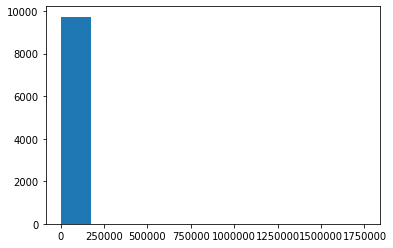

In [19]:
plt.hist(lens)
plt.show()

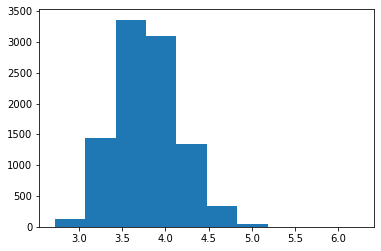

In [10]:
plt.hist(np.log10(lens))
plt.show()

In [11]:
np.percentile(lens, 25), np.percentile(lens, 50), np.percentile(lens, 75), np.percentile(lens, 90), np.percentile(lens, 95)

(3355.5, 5878.0, 10696.5, 18828.400000000005, 26840.2)

In [12]:
np.mean(np.log10(lens)), 10**np.mean(np.log10(lens)), np.std(np.log10(lens)), (np.mean(np.log10(lens)) + 2*np.std(np.log10(lens))), 10**(np.mean(np.log10(lens)) + 2*np.std(np.log10(lens)))

(3.789338942936446,
 6156.571717943955,
 0.3672135872141946,
 4.523766117364835,
 33401.51128636281)

In [13]:
from keras.preprocessing.sequence import pad_sequences

x = pad_sequences(sequences, maxlen=limite_texto)

print('Shape of data tensor:', x.shape)

Shape of data tensor: (9739, 40000)


In [14]:
x.shape, y.shape

((9739, 40000), (9739, 10))

In [15]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.layers.core import Dropout

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta',  metrics=["categorical_accuracy"])
model.summary()

W0225 13:37:00.545092 140155815114560 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0225 13:37:00.577612 140155815114560 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0225 13:37:00.580900 140155815114560 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0225 13:37:00.611309 140155815114560 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is d

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40000, 50)         15915900  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2000000)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                128000064 
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total para

In [16]:
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

W0225 13:37:01.313748 140155815114560 deprecation.py:323] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7791 samples, validate on 1948 samples
Epoch 1/20
7791/7791 [==============================] - 55s 7ms/step - loss: 2.1836 - categorical_accuracy: 0.3047 - val_loss: 1.9866 - val_categorical_accuracy: 0.1976
Epoch 2/20
7791/7791 [==============================] - 51s 6ms/step - loss: 1.7105 - categorical_accuracy: 0.4146 - val_loss: 1.4751 - val_categorical_accuracy: 0.4723
Epoch 3/20
7791/7791 [==============================] - 51s 7ms/step - loss: 1.1026 - categorical_accuracy: 0.6406 - val_loss: 1.2788 - val_categorical_accuracy: 0.5246
Epoch 4/20
7791/7791 [==============================] - 50s 6ms/step - loss: 0.6374 - categorical_accuracy: 0.8057 - val_loss: 1.2235 - val_categorical_accuracy: 0.5893
Epoch 5/20
7791/7791 [==============================] - 50s 6ms/step - loss: 0.3374 - categorical_accuracy: 0.9054 - val_loss: 1.2671 - val_categorical_accuracy: 0.6217
Epoch 6/20
7791/7791 [==============================] - 51s 6ms/step - loss: 0.2246 - categorical_accuracy:

In [18]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.layers.core import Dropout

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta',  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40000, 50)         15915900  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2000000)           0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                128000064 
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                2570      
Total para

ResourceExhaustedError: OOM when allocating tensor with shape[2000000,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_2/Adadelta/mul_6}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
